In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import cifar100
import cv2

# import data

In [35]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='coarse')

In [36]:
X_train.shape

(50000, 32, 32, 3)

# Understanding Dataset

In [37]:
unique_labels = np.unique(y_train)
print(f"Unique numerical labels in y_train: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}\n")

# Class names
class_names = ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

Unique numerical labels in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Number of unique labels: 20

0: aquatic mammals
1: fish
2: flowers
3: food containers
4: fruit and vegetables
5: household electrical devices
6: household furniture
7: insects
8: large carnivores
9: large man-made outdoor things
10: large natural outdoor scenes
11: large omnivores and herbivores
12: medium-sized mammals
13: non-insect invertebrates
14: people
15: reptiles
16: small mammals
17: trees
18: vehicles 1
19: vehicles 2


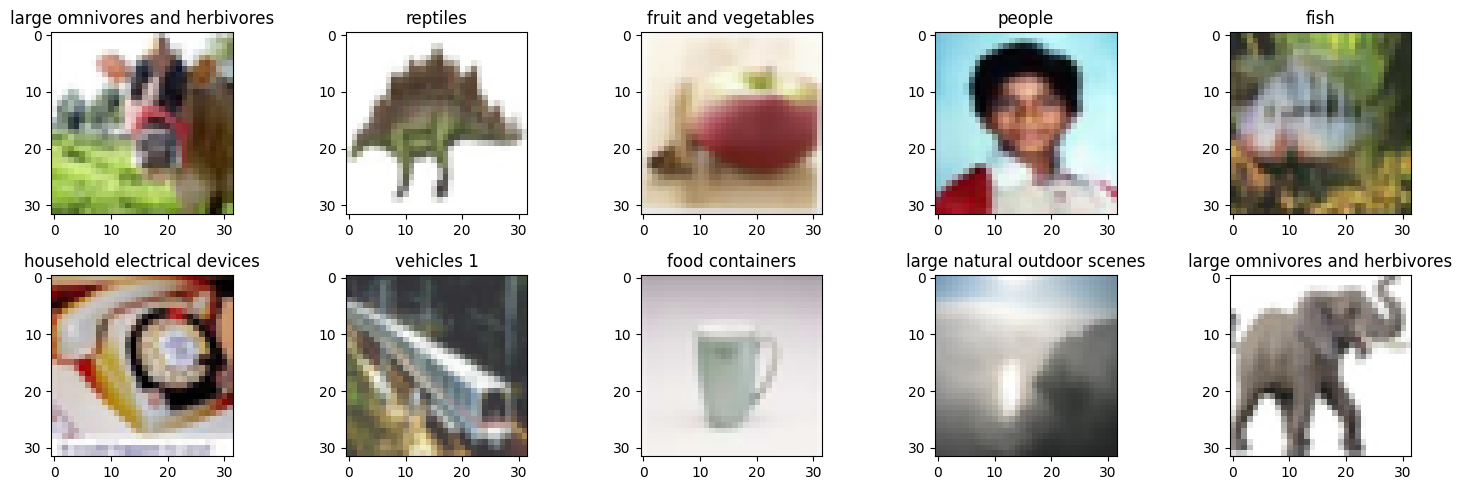

In [38]:
n = 10
fix, axes= plt.subplots(int(n/5), 5, figsize=(15, 5))
axes = axes.flatten()
for i in range(n):
    axes[i].imshow(X_train[i])
    axes[i].set_title(f"{class_names[int(y_train[i])]}")
plt.tight_layout()
plt.show()

# Change image size

In [11]:
# # # Pre-allocate the array with the target shape
# import gc
# X_train_s = X_train[:1000]
# y_train = y_train[:1000]

# X_test_s  = X_test[:200]
# y_test = y_test[:200]


# X_train_s_resized = np.zeros((1000, 224, 224, 3), dtype=np.uint8)
# # Fill it incrementally
# for i in range(len(X_train_s)):
#     X_train_s_resized[i] = cv2.resize(X_train_s[i], (224, 224))
# # Free original
# del X_train_s
# gc.collect()

# # Pre-allocate the array with the target shape
# X_test_s_resized = np.zeros((200, 224, 224, 3), dtype=np.uint8)
# # Fill it incrementally
# for i in range(len(X_test_s)):
#     X_test_s_resized[i] = cv2.resize(X_test_s[i], (224, 224))
# # Free original
# del X_train
# gc.collect()

# # Convert to float32 and normalize
# X_train = X_train_s_resized.astype(np.float32) / 255.0
# X_test = X_test_s_resized.astype(np.float32) / 255.0

# # Free uint8 arrays
# del X_train_s_resized, X_test_s_resized
# gc.collect()

0

# GoogLeNet model with X_train.shape = (sample, 224, 224, 3)

## resize with data_augumentation during training

In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [40]:
X_train = X_train[:8000].astype(np.float32) / 255.0
y_train = y_train[:8000]

X_test = X_test[:2000].astype(np.float32) / 255.0
y_test = y_test[:2000]

In [41]:
def create_datasets(X_train, y_train, X_test, y_test, batch_size=64):
    # Training dataset with augmentation
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
    train_ds = train_ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    # train_ds = train_ds.map(lambda x, y: (
    #     tf.image.random_brightness(x, max_delta=0.2), y))
    # train_ds = train_ds.map(lambda x, y: (
    #     tf.image.random_contrast(x, lower=0.8, upper=1.2), y))
    train_ds = train_ds.shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Validation dataset without augmentation (only resize)
    val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds

# Create datasets
train_ds, val_ds = create_datasets(X_train, y_train, X_test, y_test, batch_size=64)

input_layer = keras.layers.Input(shape=(224, 224, 3))

C1_layer = keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='SAME')(input_layer)
C1_layer = keras.layers.BatchNormalization()(C1_layer)
C1_layer = keras.layers.ReLU()(C1_layer)
pool1_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='SAME')(C1_layer)

C2_layer = keras.layers.Conv2D(filters=64, kernel_size=(1, 1))(pool1_layer)
C2_layer = keras.layers.BatchNormalization()(C2_layer)
C2_layer = keras.layers.ReLU()(C2_layer)

C3_layer = keras.layers.Conv2D(filters=192, kernel_size=(3, 3), padding='SAME')(C2_layer)
C3_layer = keras.layers.BatchNormalization()(C3_layer)
C3_layer = keras.layers.ReLU()(C3_layer)
pool3_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='SAME')(C3_layer)
## output_size(28, 28, 192)


## Inception 3a
#Branch 1
I3a_1 = keras.layers.Conv2D(filters= 64, kernel_size=(1, 1))(pool3_layer)
I3a_1 = keras.layers.BatchNormalization()(I3a_1)
I3a_1 = keras.layers.ReLU()(I3a_1)

#Branch 2
I3a_2 = keras.layers.Conv2D(filters=96, kernel_size=(1, 1))(pool3_layer)
I3a_2 = keras.layers.BatchNormalization()(I3a_2)
I3a_2 = keras.layers.ReLU()(I3a_2)
I3a_2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME')(I3a_2)
I3a_2 = keras.layers.BatchNormalization()(I3a_2)
I3a_2 = keras.layers.ReLU()(I3a_2)

#Branch3
I3a_3 = keras.layers.Conv2D(filters=16 ,kernel_size=(1, 1))(pool3_layer)
I3a_3 = keras.layers.BatchNormalization()(I3a_3)
I3a_3 = keras.layers.ReLU()(I3a_3)
I3a_3 = keras.layers.Conv2D(filters=32 ,kernel_size=(5, 5), padding='SAME')(I3a_3)
I3a_3 = keras.layers.BatchNormalization()(I3a_3)
I3a_3 = keras.layers.ReLU()(I3a_3)

#Branch 4
I3a_4 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='SAME')(pool3_layer)
I3a_4 = keras.layers.Conv2D(filters=32 ,kernel_size=(1, 1))(I3a_4)
I3a_4 = keras.layers.BatchNormalization()(I3a_4)
I3a_4 = keras.layers.ReLU()(I3a_4)

Inception_3a = keras.layers.Concatenate(axis=-1)([I3a_1, I3a_2, I3a_3, I3a_4])
## output_size(28, 28, (64 + 128 + 32 + 32 = 256 channels))


## Inception 3b
#Branch 1
I3b_1 = keras.layers.Conv2D(filters= 128, kernel_size=(1, 1))(Inception_3a)
I3b_1 = keras.layers.BatchNormalization()(I3b_1)
I3b_1 = keras.layers.ReLU()(I3b_1)

#Branch 2
I3b_2 = keras.layers.Conv2D(filters=128, kernel_size=(1, 1))(Inception_3a)
I3b_2 = keras.layers.BatchNormalization()(I3b_2)
I3b_2 = keras.layers.ReLU()(I3b_2)
I3b_2 = keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation='relu', padding='SAME')(I3b_2)
I3b_2 = keras.layers.BatchNormalization()(I3b_2)
I3b_2 = keras.layers.ReLU()(I3b_2)

#Branch3
I3b_3 = keras.layers.Conv2D(filters=32 ,kernel_size=(1, 1))(Inception_3a)
I3b_3 = keras.layers.BatchNormalization()(I3b_3)
I3b_3 = keras.layers.ReLU()(I3b_3)
I3b_3 = keras.layers.Conv2D(filters=96 ,kernel_size=(5, 5), padding='SAME')(I3b_3)
I3b_3 = keras.layers.BatchNormalization()(I3b_3)
I3b_3 = keras.layers.ReLU()(I3b_3)

#Branch 4
I3b_4 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='SAME')(Inception_3a)
I3b_4 = keras.layers.Conv2D(filters=64 ,kernel_size=(1, 1))(I3b_4)
I3b_4 = keras.layers.BatchNormalization()(I3b_4)
I3b_4 = keras.layers.ReLU()(I3b_4)

Inception_3b = keras.layers.Concatenate(axis=-1)([I3b_1, I3b_2, I3b_3, I3b_4])
## output_size(28, 28, (128 + 192 + 96 + 64 = 480 channels))


pool4_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), padding='SAME', strides=2)(Inception_3b)
## output_size(14, 14, 480)


## Inception 4a
#Branch 1
I4a_1 = keras.layers.Conv2D(filters= 192, kernel_size=(1, 1))(pool4_layer)
I4a_1 = keras.layers.BatchNormalization()(I4a_1)
I4a_1 = keras.layers.ReLU()(I4a_1)

#Branch 2
I4a_2 = keras.layers.Conv2D(filters=96, kernel_size=(1, 1))(pool4_layer)
I4a_2 = keras.layers.BatchNormalization()(I4a_2)
I4a_2 = keras.layers.ReLU()(I4a_2)
I4a_2 = keras.layers.Conv2D(filters=208, kernel_size=(3, 3), padding='SAME')(I4a_2)
I4a_2 = keras.layers.BatchNormalization()(I4a_2)
I4a_2 = keras.layers.ReLU()(I4a_2)

#Branch3
I4a_3 = keras.layers.Conv2D(filters=16 ,kernel_size=(1, 1))(pool4_layer)
I4a_3 = keras.layers.BatchNormalization()(I4a_3)
I4a_3 = keras.layers.ReLU()(I4a_3)
I4a_3 = keras.layers.Conv2D(filters=48 ,kernel_size=(5, 5), padding='SAME')(I4a_3)
I4a_3 = keras.layers.BatchNormalization()(I4a_3)
I4a_3 = keras.layers.ReLU()(I4a_3)

#Branch 4
I4a_4 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='SAME')(pool4_layer)
I4a_4 = keras.layers.Conv2D(filters=64 ,kernel_size=(1, 1))(I4a_4)
I4a_4 = keras.layers.BatchNormalization()(I4a_4)
I4a_4 = keras.layers.ReLU()(I4a_4)

Inception_4a = keras.layers.Concatenate(axis=-1)([I4a_1, I4a_2, I4a_3, I4a_4])
## output_size(14, 14, (192 + 208 + 48 + 64 = 512 channels))


flatten_layer = keras.layers.GlobalAveragePooling2D()(Inception_4a)
Dens1_layer = keras.layers.Dropout(rate = 0.4)(flatten_layer)


output_layer = keras.layers.Dense(20, activation= 'softmax')(Dens1_layer)

model = keras.Model(input_layer, output_layer)
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    loss= 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [42]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 112, 112, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d_84[0][0]']              
 alization)                     )                                                           

In [43]:
# callbacks = [
#     keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,           # Reduce LR by half
#         patience=3,           # Wait 3 epochs with no improvement
#         min_lr=1e-6           # Minimum learning rate
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=10,          # Stop after 10 epochs without improvement
#         restore_best_weights=True
#     )
# ]

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_main_output_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_main_output_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_main_output_sparse_categorical_accuracy',
        save_best_only=True,
        mode='max'
    )
]

GoogLe_model = model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=callbacks)

Epoch 1/25
125/125 [==============================] - 2994s 24s/step - loss: 2.6920 - sparse_categorical_accuracy: 0.1756 - val_loss: 3.4923 - val_sparse_categorical_accuracy: 0.0490 - lr: 0.0010
Epoch 2/25
125/125 [==============================] - 744s 6s/step - loss: 2.4768 - sparse_categorical_accuracy: 0.2288 - val_loss: 2.9131 - val_sparse_categorical_accuracy: 0.1085 - lr: 0.0010
Epoch 3/25
125/125 [==============================] - 989s 8s/step - loss: 2.3537 - sparse_categorical_accuracy: 0.2635 - val_loss: 2.5154 - val_sparse_categorical_accuracy: 0.2080 - lr: 0.0010
Epoch 4/25
125/125 [==============================] - 1118s 9s/step - loss: 2.2621 - sparse_categorical_accuracy: 0.2937 - val_loss: 2.3128 - val_sparse_categorical_accuracy: 0.2880 - lr: 0.0010
Epoch 5/25
125/125 [==============================] - 1097s 9s/step - loss: 2.1435 - sparse_categorical_accuracy: 0.3234 - val_loss: 2.4381 - val_sparse_categorical_accuracy: 0.2555 - lr: 0.0010
Epoch 6/25
125/125 [======

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x000001B5C7BF2310>
Traceback (most recent call last):
  File "C:\Users\ebsor\anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\ebsor\anaconda3\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
KeyboardInterrupt: 

KeyboardInterrupt



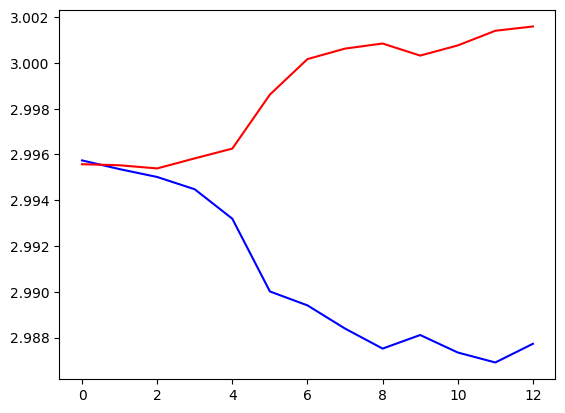

In [44]:
plt.plot(GoogLe_model.history['loss'], color='blue')
plt.plot(GoogLe_model.history['val_loss'], color='red')

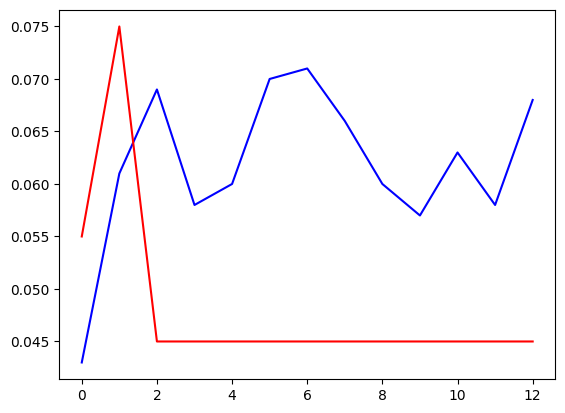

In [45]:
plt.plot(GoogLe_model.history['sparse_categorical_accuracy'], color='blue')
plt.plot(GoogLe_model.history['val_sparse_categorical_accuracy'], color='red')

ValueError: Could not save to JPEG for display

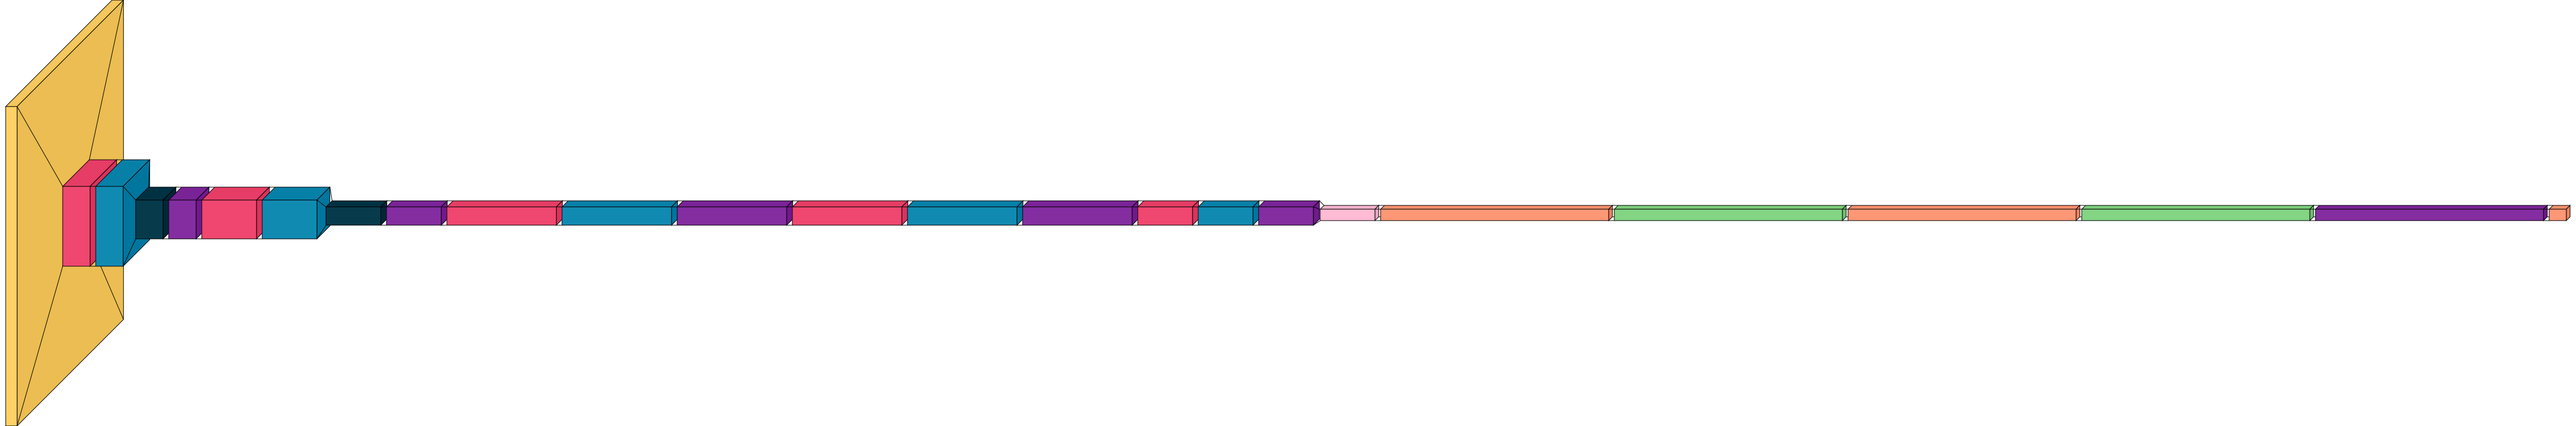

In [68]:
import visualkeras
visualkeras.layered_view(model)